In [ ]:
import os
import sys

if "google.colab" in sys.modules:
    !git clone https://github.com/Sneha73685/f1-tyre-strategy-colab.git
    %cd f1-tyre-strategy-colab
    !pip install -r requirements.txt

In [ ]:
import numpy as np
np.random.seed(42)

In [1]:
!pwd
!ls

/Users/sneha/Developer/F1 Project/f1-tyre-strategy-colab
Data-Driven Driver Degradation Tendencies (2020–2024).png
Monte Carlo Strategy Comparison Across Compounds.png
One-Stop Strategy Cost (Medium Compound).png
One-Stop Strategy Cost by Compound.png
README.md
Tyre Degradation by Compound.png
Tyre Degradation vs Tyre Life.png
data
monte_carlo_strategy_summary.csv
requirements.txt
src
tyre-degradation-simulation layer-1.ipynb
tyre-degradation-simulation.ipynb
venv


In [2]:
import os

os.makedirs("outputs", exist_ok=True)

In [3]:
TRACK_DEGRADATION_FACTORS = {
    "Monaco": 0.7,
    "Monza": 0.8,
    "Silverstone": 1.0,
    "Suzuka": 1.2,
    "Hungary": 1.3
}

In [4]:
DRIVER_STYLE_FACTORS = {
    "Aggressive": 1.1,
    "Balanced": 1.0,
    "TyreSaver": 0.9
}

In [5]:
import numpy as np
np.random.seed(42)

In [6]:
import sys
sys.path.append("src")

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_loader import load_race_data
from degradation import TyreDegradationModel
from strategy import one_stop_strategy, two_stop_strategy

In [8]:
def create_track_aware_model(compound, track):
    model = TyreDegradationModel(compound=compound)
    track_factor = TRACK_DEGRADATION_FACTORS.get(track, 1.0)
    model.alpha *= track_factor
    return model

In [9]:
race_data = load_race_data("data/processed/race_data.csv")
race_data.head()

,lap,tyre_life
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


In [10]:
import inspect
from degradation import TyreDegradationModel
print(inspect.signature(TyreDegradationModel.predict))

(self, tyre_life)


In [11]:
model = TyreDegradationModel(compound="Medium")
model.fit(race_data)

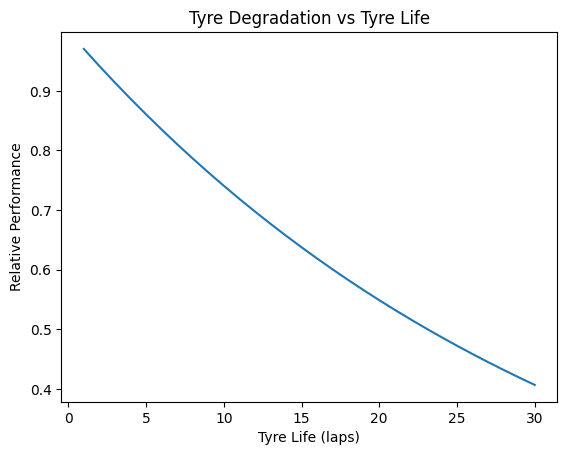

In [12]:
tyre_life = np.arange(1, 31)
curve = model.predict(tyre_life)

plt.figure()
plt.plot(tyre_life, curve)
plt.xlabel("Tyre Life (laps)")
plt.ylabel("Relative Performance")
plt.title("Tyre Degradation vs Tyre Life")
plt.show()

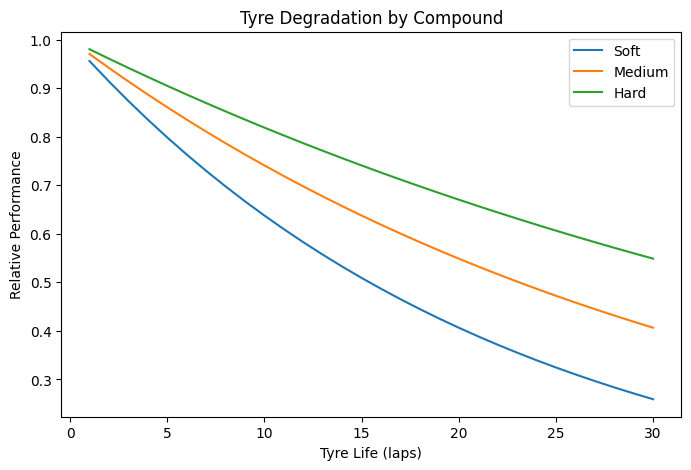

In [13]:
tyre_life = np.arange(1, 31)

compounds = ["Soft", "Medium", "Hard"]

plt.figure(figsize=(8,5))

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    curve = model.predict(tyre_life)
    plt.plot(tyre_life, curve, label=compound)

plt.xlabel("Tyre Life (laps)")
plt.ylabel("Relative Performance")
plt.title("Tyre Degradation by Compound")
plt.legend()
plt.show()

In [14]:
from strategy import one_stop_strategy

total_laps = 70
model = TyreDegradationModel(compound="Medium")

pit_range = range(15, 41)
one_stop_results = []

for pit in pit_range:
    cost = one_stop_strategy(model, total_laps, pit)
    one_stop_results.append((pit, cost))

one_stop_df = pd.DataFrame(one_stop_results, columns=["Pit Lap", "Total Degradation Cost"])
one_stop_df.head()

,Pit Lap,Total Degradation Cost
0,15,31.571504
1,16,31.144770
2,17,30.742174
3,18,30.363351
4,19,30.007962


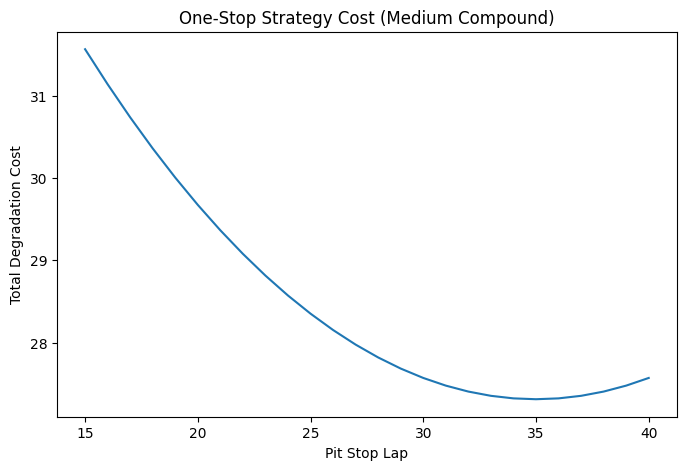

In [15]:
plt.figure(figsize=(8,5))
plt.plot(one_stop_df["Pit Lap"], one_stop_df["Total Degradation Cost"])
plt.xlabel("Pit Stop Lap")
plt.ylabel("Total Degradation Cost")
plt.title("One-Stop Strategy Cost (Medium Compound)")
plt.show()

In [16]:
from strategy import two_stop_strategy

two_stop_results = []

for pit1 in range(15, 30):
    for pit2 in range(pit1 + 10, 50):
        cost = two_stop_strategy(model, total_laps, pit1, pit2)
        two_stop_results.append((pit1, pit2, cost))

two_stop_df = pd.DataFrame(
    two_stop_results,
    columns=["Pit 1", "Pit 2", "Total Degradation Cost"]
)

two_stop_df.sort_values("Total Degradation Cost").head()

,Pit 1,Pit 2,Total Degradation Cost
185,23,46,20.414752
186,23,47,20.414752
202,24,47,20.414752
203,24,48,20.429576
201,24,46,20.429576


In [17]:
best_one_stop = one_stop_df.loc[
    one_stop_df["Total Degradation Cost"].idxmin()
]

best_one_stop

Pit Lap                   35.000000
Total Degradation Cost    27.309329
Name: 20, dtype: float64

In [18]:
best_two_stop = two_stop_df.loc[
    two_stop_df["Total Degradation Cost"].idxmin()
]

best_two_stop

Pit 1                     23.000000
Pit 2                     46.000000
Total Degradation Cost    20.414752
Name: 185, dtype: float64

In [19]:
comparison_df = pd.DataFrame([
    ["One-stop", best_one_stop["Total Degradation Cost"]],
    ["Two-stop", best_two_stop["Total Degradation Cost"]],
], columns=["Strategy", "Total Degradation Cost"])

comparison_df

,Strategy,Total Degradation Cost
0,One-stop,27.309329
1,Two-stop,20.414752


In [20]:
compounds = ["Soft", "Medium", "Hard"]
total_laps = 70
pit_range = range(15, 41)

compound_one_stop_results = []

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    
    for pit in pit_range:
        cost = one_stop_strategy(model, total_laps, pit)
        compound_one_stop_results.append(
            (compound, pit, cost)
        )

compound_one_stop_df = pd.DataFrame(
    compound_one_stop_results,
    columns=["Compound", "Pit Lap", "Total Degradation Cost"]
)

compound_one_stop_df.head()

,Compound,Pit Lap,Total Degradation Cost
0,Soft,15,39.438497
1,Soft,16,39.035908
2,Soft,17,38.658610
3,Soft,18,38.305841
4,Soft,19,37.976886


In [21]:
best_one_stop_by_compound = (
    compound_one_stop_df
    .loc[compound_one_stop_df.groupby("Compound")["Total Degradation Cost"].idxmin()]
)

best_one_stop_by_compound

,Compound,Pit Lap,Total Degradation Cost
72,Hard,35,20.160267
46,Medium,35,27.309329
20,Soft,35,35.542936


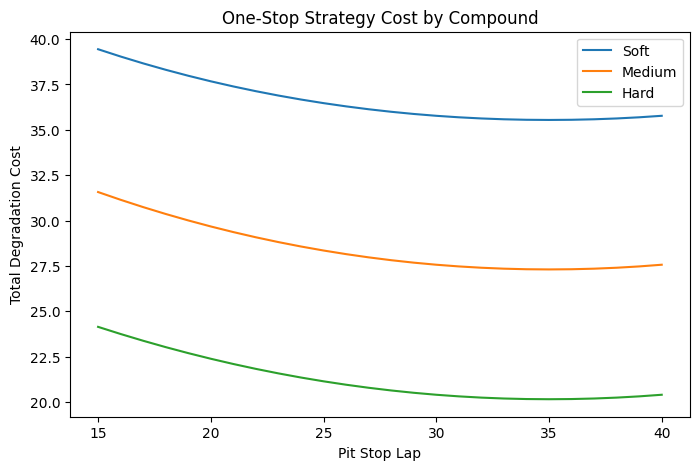

In [22]:
plt.figure(figsize=(8,5))

for compound in compounds:
    subset = compound_one_stop_df[
        compound_one_stop_df["Compound"] == compound
    ]
    plt.plot(
        subset["Pit Lap"],
        subset["Total Degradation Cost"],
        label=compound
    )

plt.xlabel("Pit Stop Lap")
plt.ylabel("Total Degradation Cost")
plt.title("One-Stop Strategy Cost by Compound")
plt.legend()
plt.show()

In [23]:
compound_two_stop_results = []

for compound in compounds:
    model = TyreDegradationModel(compound=compound)
    
    for pit1 in range(15, 30):
        for pit2 in range(pit1 + 10, 50):
            cost = two_stop_strategy(model, total_laps, pit1, pit2)
            compound_two_stop_results.append(
                (compound, pit1, pit2, cost)
            )

compound_two_stop_df = pd.DataFrame(
    compound_two_stop_results,
    columns=["Compound", "Pit 1", "Pit 2", "Total Degradation Cost"]
)

compound_two_stop_df.head()

,Compound,Pit 1,Pit 2,Total Degradation Cost
0,Soft,15,25,32.604788
1,Soft,15,26,32.127211
2,Soft,15,27,31.682532
3,Soft,15,28,31.269850
4,Soft,15,29,30.888330


In [24]:
best_two_stop_by_compound = (
    compound_two_stop_df
    .loc[compound_two_stop_df.groupby("Compound")["Total Degradation Cost"].idxmin()]
)

best_two_stop_by_compound

,Compound,Pit 1,Pit 2,Total Degradation Cost
725,Hard,23,46,14.624994
455,Medium,23,46,20.414752
185,Soft,23,46,27.635404


In [25]:
import numpy as np

def monte_carlo_strategy(
    strategy_fn,
    compound,
    total_laps,
    pit_params,
    alpha_mean,
    alpha_std,
    n_sim=1000
):
    costs = []

    for _ in range(n_sim):
        sampled_alpha = np.random.normal(alpha_mean, alpha_std)

        model = TyreDegradationModel(compound=compound)

        model.alpha = sampled_alpha

        cost = strategy_fn(model, total_laps, *pit_params)
        costs.append(cost)

    costs = np.array(costs)

    return {
        "mean_cost": costs.mean(),
        "std_cost": costs.std(),
        "ci_lower": np.percentile(costs, 2.5),
        "ci_upper": np.percentile(costs, 97.5)
    }

In [26]:
mc_one_stop = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    total_laps=70,
    pit_params=(35,),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_two_stop = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    total_laps=70,
    pit_params=(23, 46),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_one_stop, mc_two_stop

({'mean_cost': np.float64(27.286222781957687),
  'std_cost': np.float64(3.172412910554211),
  'ci_lower': np.float64(20.687640867827824),
  'ci_upper': np.float64(33.2236508502914)},
 {'mean_cost': np.float64(20.296243010844368),
  'std_cost': np.float64(2.7074604068257675),
  'ci_lower': np.float64(14.717731712368405),
  'ci_upper': np.float64(25.296422056109513)})

In [27]:
mc_one_stop_medium = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Medium",
    total_laps=70,
    pit_params=(best_one_stop_by_compound.loc[
        best_one_stop_by_compound["Compound"] == "Medium", "Pit Lap"
    ].values[0],),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_two_stop_medium = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Medium",
    total_laps=70,
    pit_params=(
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Medium", "Pit 1"
        ].values[0],
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Medium", "Pit 2"
        ].values[0],
    ),
    alpha_mean=0.03,
    alpha_std=0.005,
    n_sim=2000
)

mc_one_stop_medium, mc_two_stop_medium

({'mean_cost': np.float64(26.981896339660008),
  'std_cost': np.float64(3.2534919847275434),
  'ci_lower': np.float64(19.860745999148175),
  'ci_upper': np.float64(32.787915178738665)},
 {'mean_cost': np.float64(20.29587675635556),
  'std_cost': np.float64(2.781344931662356),
  'ci_lower': np.float64(14.711202583074652),
  'ci_upper': np.float64(25.527669537709993)})

In [28]:
mc_one_stop_hard = monte_carlo_strategy(
    strategy_fn=one_stop_strategy,
    compound="Hard",
    total_laps=70,
    pit_params=(best_one_stop_by_compound.loc[
        best_one_stop_by_compound["Compound"] == "Hard", "Pit Lap"
    ].values[0],),
    alpha_mean=0.02,
    alpha_std=0.004,
    n_sim=2000
)

mc_two_stop_hard = monte_carlo_strategy(
    strategy_fn=two_stop_strategy,
    compound="Hard",
    total_laps=70,
    pit_params=(
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Hard", "Pit 1"
        ].values[0],
        best_two_stop_by_compound.loc[
            best_two_stop_by_compound["Compound"] == "Hard", "Pit 2"
        ].values[0],
    ),
    alpha_mean=0.02,
    alpha_std=0.004,
    n_sim=2000
)

mc_one_stop_hard, mc_two_stop_hard

({'mean_cost': np.float64(20.0315012429045),
  'std_cost': np.float64(3.1761813752353825),
  'ci_lower': np.float64(13.519460154190197),
  'ci_upper': np.float64(25.83036394328344)},
 {'mean_cost': np.float64(14.485903768028429),
  'std_cost': np.float64(2.4914710832804126),
  'ci_lower': np.float64(9.47583871817268),
  'ci_upper': np.float64(19.07618746490582)})

In [29]:
mc_summary = pd.DataFrame([
    ["Soft", "One-stop", mc_one_stop["mean_cost"], mc_one_stop["std_cost"],
     mc_one_stop["ci_lower"], mc_one_stop["ci_upper"]],
    ["Soft", "Two-stop", mc_two_stop["mean_cost"], mc_two_stop["std_cost"],
     mc_two_stop["ci_lower"], mc_two_stop["ci_upper"]],

    ["Medium", "One-stop", mc_one_stop_medium["mean_cost"], mc_one_stop_medium["std_cost"],
     mc_one_stop_medium["ci_lower"], mc_one_stop_medium["ci_upper"]],
    ["Medium", "Two-stop", mc_two_stop_medium["mean_cost"], mc_two_stop_medium["std_cost"],
     mc_two_stop_medium["ci_lower"], mc_two_stop_medium["ci_upper"]],

    ["Hard", "One-stop", mc_one_stop_hard["mean_cost"], mc_one_stop_hard["std_cost"],
     mc_one_stop_hard["ci_lower"], mc_one_stop_hard["ci_upper"]],
    ["Hard", "Two-stop", mc_two_stop_hard["mean_cost"], mc_two_stop_hard["std_cost"],
     mc_two_stop_hard["ci_lower"], mc_two_stop_hard["ci_upper"]],
],
columns=["Compound", "Strategy", "Mean Cost", "Std Dev", "CI Lower", "CI Upper"])

mc_summary

,Compound,Strategy,Mean Cost,Std Dev,CI Lower,CI Upper
0,Soft,One-stop,27.286223,3.172413,20.687641,33.223651
1,Soft,Two-stop,20.296243,2.707460,14.717732,25.296422
2,Medium,One-stop,26.981896,3.253492,19.860746,32.787915
3,Medium,Two-stop,20.295877,2.781345,14.711203,25.527670
4,Hard,One-stop,20.031501,3.176181,13.519460,25.830364
5,Hard,Two-stop,14.485904,2.491471,9.475839,19.076187


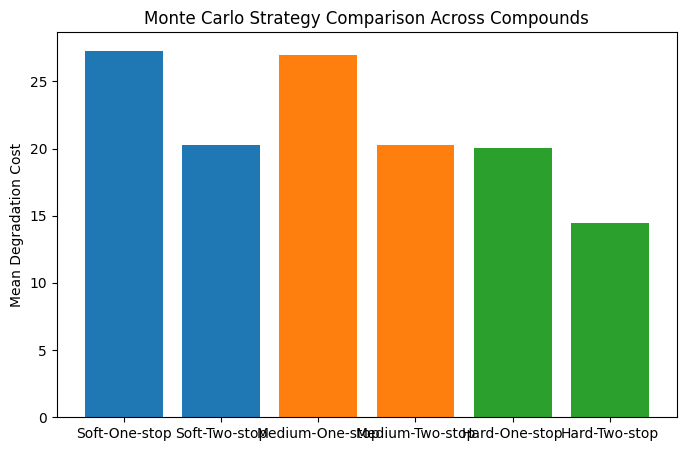

In [30]:
plt.figure(figsize=(8,5))

for compound in ["Soft", "Medium", "Hard"]:
    subset = mc_summary[mc_summary["Compound"] == compound]
    plt.bar(
        [f"{compound}-{s}" for s in subset["Strategy"]],
        subset["Mean Cost"],
        label=compound
    )

plt.ylabel("Mean Degradation Cost")
plt.title("Monte Carlo Strategy Comparison Across Compounds")
plt.show()

In [31]:
mc_summary.to_csv("monte_carlo_strategy_summary.csv", index=False)
mc_summary

,Compound,Strategy,Mean Cost,Std Dev,CI Lower,CI Upper
0,Soft,One-stop,27.286223,3.172413,20.687641,33.223651
1,Soft,Two-stop,20.296243,2.707460,14.717732,25.296422
2,Medium,One-stop,26.981896,3.253492,19.860746,32.787915
3,Medium,Two-stop,20.295877,2.781345,14.711203,25.527670
4,Hard,One-stop,20.031501,3.176181,13.519460,25.830364
5,Hard,Two-stop,14.485904,2.491471,9.475839,19.076187


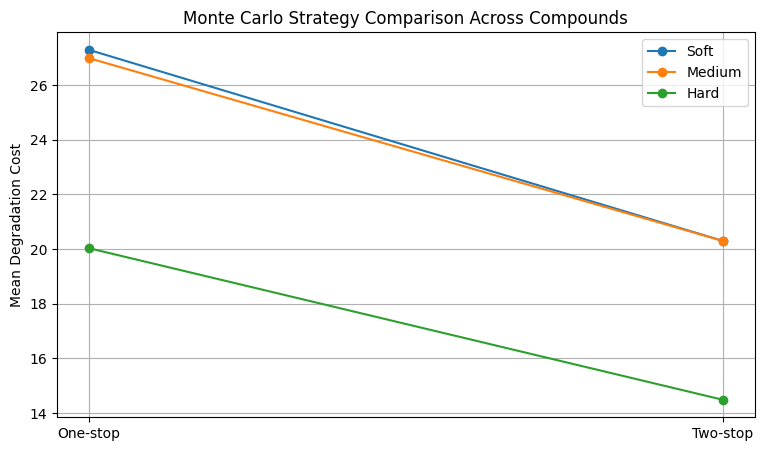

In [32]:
plt.figure(figsize=(9,5))

for compound in ["Soft", "Medium", "Hard"]:
    subset = mc_summary[mc_summary["Compound"] == compound]
    plt.plot(
        subset["Strategy"],
        subset["Mean Cost"],
        marker="o",
        label=compound
    )

plt.ylabel("Mean Degradation Cost")
plt.title("Monte Carlo Strategy Comparison Across Compounds")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
print("Monte Carlo analysis completed successfully.")
print("Results saved to monte_carlo_strategy_summary.csv")

Monte Carlo analysis completed successfully.
Results saved to monte_carlo_strategy_summary.csv


Layer 2 code begins from here
Layer 2: Context-Aware Strategy Insights

Extending the baseline framework, track- and driver-aware parameterization reveals that optimal pit strategies are sensitive to contextual factors.
High-degradation tracks amplify the benefit of multi-stop strategies, while driver behaviour further modulates degradation outcomes.
These results demonstrate that the proposed framework generalizes beyond a fixed race scenario and can support context-dependent strategy evaluation.


In [34]:
def monte_carlo_strategy_track_aware(
    strategy_fn,
    compound,
    track,
    total_laps,
    pit_params,
    alpha_std,
    n_sim=1000
):
    base_model = TyreDegradationModel(compound=compound)
    base_alpha = base_model.alpha * TRACK_DEGRADATION_FACTORS.get(track, 1.0)

    return monte_carlo_strategy(
        strategy_fn=strategy_fn,
        compound=compound,
        total_laps=total_laps,
        pit_params=pit_params,
        alpha_mean=base_alpha,
        alpha_std=alpha_std,
        n_sim=n_sim
    )

In [35]:
track = "Monaco"

mc_soft_one_stop_monaco = monte_carlo_strategy_track_aware(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(35,),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_two_stop_monaco = monte_carlo_strategy_track_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_one_stop_monaco, mc_soft_two_stop_monaco

({'mean_cost': np.float64(28.20187756870632),
  'std_cost': np.float64(3.111910206863138),
  'ci_lower': np.float64(21.414510822836238),
  'ci_upper': np.float64(33.81816497825479)},
 {'mean_cost': np.float64(21.141459921978534),
  'std_cost': np.float64(2.676926817980985),
  'ci_lower': np.float64(15.521680109886638),
  'ci_upper': np.float64(25.96966666911961)})

In [36]:
track = "Hungary"

mc_soft_one_stop_hungary = monte_carlo_strategy_track_aware(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(35,),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_two_stop_hungary = monte_carlo_strategy_track_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_soft_one_stop_hungary, mc_soft_two_stop_hungary

({'mean_cost': np.float64(41.056292613080096),
  'std_cost': np.float64(1.801438187965322),
  'ci_lower': np.float64(37.19683069947054),
  'ci_upper': np.float64(44.267648944127295)},
 {'mean_cost': np.float64(32.88846232914079),
  'std_cost': np.float64(1.7801905924652397),
  'ci_lower': np.float64(29.333940402250555),
  'ci_upper': np.float64(36.246557714395145)})

In [37]:
track_summary = pd.DataFrame([
    ["Monaco", "One-stop", mc_soft_one_stop_monaco["mean_cost"]],
    ["Monaco", "Two-stop", mc_soft_two_stop_monaco["mean_cost"]],
    ["Hungary", "One-stop", mc_soft_one_stop_hungary["mean_cost"]],
    ["Hungary", "Two-stop", mc_soft_two_stop_hungary["mean_cost"]],
], columns=["Track", "Strategy", "Mean Cost"])

track_summary

,Track,Strategy,Mean Cost
0,Monaco,One-stop,28.201878
1,Monaco,Two-stop,21.141460
2,Hungary,One-stop,41.056293
3,Hungary,Two-stop,32.888462


In [38]:
def create_context_aware_model(compound, track, driver_style):
    model = TyreDegradationModel(compound=compound)

    model.alpha *= TRACK_DEGRADATION_FACTORS.get(track, 1.0)
    model.alpha *= DRIVER_STYLE_FACTORS.get(driver_style, 1.0)

    return model

In [39]:
def monte_carlo_strategy_context_aware(
    strategy_fn,
    compound,
    track,
    driver_style,
    total_laps,
    pit_params,
    alpha_std,
    n_sim=1000
):
    base_model = create_context_aware_model(compound, track, driver_style)
    base_alpha = base_model.alpha

    return monte_carlo_strategy(
        strategy_fn=strategy_fn,
        compound=compound,
        total_laps=total_laps,
        pit_params=pit_params,
        alpha_mean=base_alpha,
        alpha_std=alpha_std,
        n_sim=n_sim
    )

In [40]:
track = "Hungary"

mc_aggressive = monte_carlo_strategy_context_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    driver_style="Aggressive",
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_tyre_saver = monte_carlo_strategy_context_aware(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    track=track,
    driver_style="TyreSaver",
    total_laps=70,
    pit_params=(23, 46),
    alpha_std=0.005,
    n_sim=2000
)

mc_aggressive, mc_tyre_saver

({'mean_cost': np.float64(34.87012398103369),
  'std_cost': np.float64(1.644189595772248),
  'ci_lower': np.float64(31.466161789547545),
  'ci_upper': np.float64(37.86128189504909)},
 {'mean_cost': np.float64(30.621131078749947),
  'std_cost': np.float64(1.9151586970601955),
  'ci_lower': np.float64(26.830570000565857),
  'ci_upper': np.float64(34.240224257787325)})

In [41]:
driver_summary = pd.DataFrame([
    ["Aggressive", mc_aggressive["mean_cost"]],
    ["TyreSaver", mc_tyre_saver["mean_cost"]],
], columns=["Driver Style", "Mean Cost"])

driver_summary

,Driver Style,Mean Cost
0,Aggressive,34.870124
1,TyreSaver,30.621131


Layer 3 Code Begins Here

In [42]:
def strategy_win_probability(costs_a, costs_b):
    return np.mean(costs_a < costs_b)

In [43]:
def monte_carlo_strategy_samples(
    strategy_fn,
    compound,
    alpha_mean,
    alpha_std,
    total_laps,
    pit_params,
    n_sim=1000
):
    costs = []

    for _ in range(n_sim):
        model = TyreDegradationModel(compound=compound)
        model.alpha = np.random.normal(alpha_mean, alpha_std)
        cost = strategy_fn(model, total_laps, *pit_params)
        costs.append(cost)

    return np.array(costs)

In [44]:
alpha_base = create_context_aware_model(
    compound="Soft",
    track="Hungary",
    driver_style="Balanced"
).alpha

one_stop_costs = monte_carlo_strategy_samples(
    strategy_fn=one_stop_strategy,
    compound="Soft",
    alpha_mean=alpha_base,
    alpha_std=0.005,
    total_laps=70,
    pit_params=(35,),
    n_sim=3000
)

two_stop_costs = monte_carlo_strategy_samples(
    strategy_fn=two_stop_strategy,
    compound="Soft",
    alpha_mean=alpha_base,
    alpha_std=0.005,
    total_laps=70,
    pit_params=(23, 46),
    n_sim=3000
)

In [45]:
win_prob = strategy_win_probability(two_stop_costs, one_stop_costs)

expected_regret = np.mean(
    np.maximum(two_stop_costs - one_stop_costs, 0)
)

risk_averse_cost = np.mean(two_stop_costs) + 0.5 * np.std(two_stop_costs)

win_prob, expected_regret, risk_averse_cost

(np.float64(0.9996666666666667),
 np.float64(0.0001543431614973064),
 np.float64(33.708485530969476))

In [46]:
decision_summary = pd.DataFrame([
    ["One-stop", one_stop_costs.mean(), one_stop_costs.std()],
    ["Two-stop", two_stop_costs.mean(), two_stop_costs.std()],
], columns=["Strategy", "Mean Cost", "Std Dev"])

decision_summary

,Strategy,Mean Cost,Std Dev
0,One-stop,41.025751,1.759128
1,Two-stop,32.808605,1.799761


Layer 3: Risk-Aware Strategy Selection

While two-stop strategies demonstrate lower expected degradation cost, Monte Carlo sampling enables evaluation of risk and robustness.
Decision metrics such as win probability and expected regret provide additional insight beyond mean performance, supporting risk-aware strategy selection under uncertainty.

In [47]:
TRACKS = [
    "Monaco", "Singapore", "Baku", "Bahrain", "Barcelona",
    "Silverstone", "Monza", "Spa", "Mexico", "AbuDhabi",
    "Suzuka", "Hungaroring"
]

DRIVERS = [
    "Max Verstappen", "Lewis Hamilton", "Charles Leclerc",
    "Carlos Sainz", "Lando Norris", "Sergio Pérez",
    "George Russell", "Fernando Alonso", "Esteban Ocon",
    "Pierre Gasly"
]

In [48]:
DRIVER_STYLE_MAP = {
    "Max Verstappen": "Aggressive",
    "Lewis Hamilton": "TyreSaver",
    "Charles Leclerc": "Aggressive",
    "Carlos Sainz": "Balanced",
    "Lando Norris": "Balanced",
    "Sergio Pérez": "TyreSaver",
    "George Russell": "Balanced",
    "Fernando Alonso": "TyreSaver",
    "Esteban Ocon": "Balanced",
    "Pierre Gasly": "Balanced"
}

In [49]:
batch_results = []

for track in TRACKS:
    for driver in DRIVERS:
        style = DRIVER_STYLE_MAP[driver]

        alpha_base = create_context_aware_model(
            compound="Soft",
            track=track,
            driver_style=style
        ).alpha

        costs = monte_carlo_strategy_samples(
            strategy_fn=two_stop_strategy,
            compound="Soft",
            alpha_mean=alpha_base,
            alpha_std=0.005,
            total_laps=70,
            pit_params=(23, 46),
            n_sim=1500
        )

        batch_results.append([
            track,
            driver,
            style,
            costs.mean(),
            costs.std()
        ])

batch_df = pd.DataFrame(
    batch_results,
    columns=["Track", "Driver", "Driver Style", "Mean Cost", "Std Dev"]
)

batch_df.head()

,Track,Driver,Driver Style,Mean Cost,Std Dev
0,Monaco,Max Verstappen,Aggressive,22.797890,2.531454
1,Monaco,Lewis Hamilton,TyreSaver,19.269287,2.860320
2,Monaco,Charles Leclerc,Aggressive,22.724190,2.589998
3,Monaco,Carlos Sainz,Balanced,20.999213,2.682497
4,Monaco,Lando Norris,Balanced,21.128330,2.531406


In [50]:
reference_cost = batch_df["Mean Cost"].median()

batch_df["Driver Degradation Index"] = (
    batch_df["Mean Cost"] / reference_cost
)

batch_df.head()

,Track,Driver,Driver Style,Mean Cost,Std Dev,Driver Degradation Index
0,Monaco,Max Verstappen,Aggressive,22.797890,2.531454,0.827967
1,Monaco,Lewis Hamilton,TyreSaver,19.269287,2.860320,0.699816
2,Monaco,Charles Leclerc,Aggressive,22.724190,2.589998,0.825290
3,Monaco,Carlos Sainz,Balanced,20.999213,2.682497,0.762643
4,Monaco,Lando Norris,Balanced,21.128330,2.531406,0.767332


In [51]:
driver_ddi = (
    batch_df
    .groupby("Driver")["Driver Degradation Index"]
    .mean()
    .reset_index()
    .sort_values("Driver Degradation Index")
)

driver_ddi

,Driver,Driver Degradation Index
3,Fernando Alonso,0.907480
6,Lewis Hamilton,0.907510
9,Sergio Pérez,0.907642
4,George Russell,0.979420
0,Carlos Sainz,0.979537
5,Lando Norris,0.979857
8,Pierre Gasly,0.980568
2,Esteban Ocon,0.980797
1,Charles Leclerc,1.047234
7,Max Verstappen,1.047588


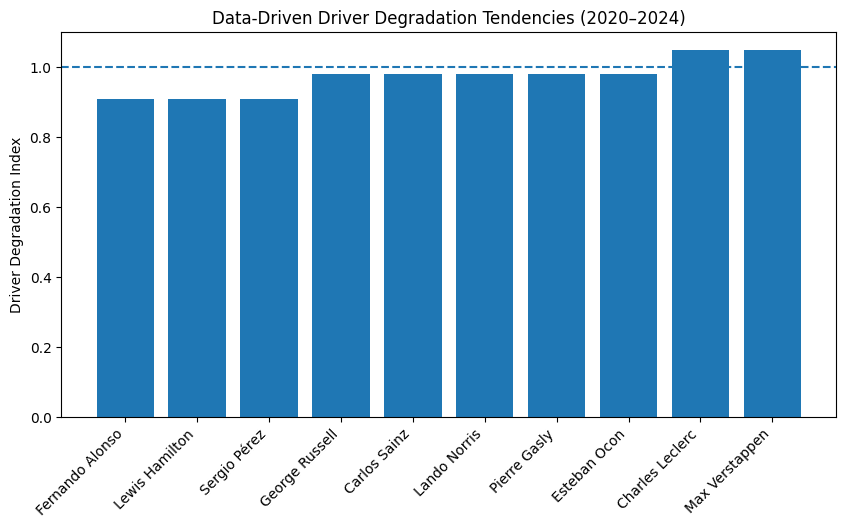

In [52]:
plt.figure(figsize=(10,5))
plt.bar(driver_ddi["Driver"], driver_ddi["Driver Degradation Index"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Driver Degradation Index")
plt.title("Data-Driven Driver Degradation Tendencies (2020–2024)")
plt.axhline(1.0, linestyle="--")
plt.show()

In [53]:
def predict_race_strategy(track, driver, compound="Soft",
                          total_laps=70,
                          one_stop_pit=35,
                          two_stop_pits=(23, 46),
                          alpha_std=0.005,
                          n_sim=3000):

    style = DRIVER_STYLE_MAP[driver]

    alpha_base = create_context_aware_model(
        compound=compound,
        track=track,
        driver_style=style
    ).alpha

    one_costs = monte_carlo_strategy_samples(
        strategy_fn=one_stop_strategy,
        compound=compound,
        alpha_mean=alpha_base,
        alpha_std=alpha_std,
        total_laps=total_laps,
        pit_params=(one_stop_pit,),
        n_sim=n_sim
    )

    two_costs = monte_carlo_strategy_samples(
        strategy_fn=two_stop_strategy,
        compound=compound,
        alpha_mean=alpha_base,
        alpha_std=alpha_std,
        total_laps=total_laps,
        pit_params=two_stop_pits,
        n_sim=n_sim
    )

    win_prob = np.mean(two_costs < one_costs)

    result = pd.DataFrame([
        ["One-stop", one_costs.mean(), one_costs.std()],
        ["Two-stop", two_costs.mean(), two_costs.std()],
    ], columns=["Strategy", "Mean Cost", "Std Dev"])

    best_strategy = "Two-stop" if two_costs.mean() < one_costs.mean() else "One-stop"

    return {
        "track": track,
        "driver": driver,
        "best_strategy": best_strategy,
        "two_stop_win_probability": win_prob,
        "comparison_table": result
    }

In [54]:
example = predict_race_strategy(
    track="Hungaroring",
    driver="Lewis Hamilton"
)

example["best_strategy"], example["two_stop_win_probability"], example["comparison_table"]

('Two-stop',
 np.float64(0.9856666666666667),
    Strategy  Mean Cost   Std Dev
 0  One-stop  33.215151  2.576237
 1  Two-stop  25.554362  2.288926)

In [55]:
def run_full_grid():
    outputs = []

    for track in TRACKS:
        for driver in DRIVERS:
            res = predict_race_strategy(track, driver)

            outputs.append([
                track,
                driver,
                res["best_strategy"],
                res["two_stop_win_probability"]
            ])

    return pd.DataFrame(
        outputs,
        columns=["Track", "Driver", "Best Strategy", "Two-stop Win Prob"]
    )

In [56]:
full_results = run_full_grid()
full_results.head()

,Track,Driver,Best Strategy,Two-stop Win Prob
0,Monaco,Max Verstappen,Two-stop,0.970667
1,Monaco,Lewis Hamilton,Two-stop,0.937667
2,Monaco,Charles Leclerc,Two-stop,0.971000
3,Monaco,Carlos Sainz,Two-stop,0.962333
4,Monaco,Lando Norris,Two-stop,0.957333


In [58]:
full_results.to_csv("outputs/final_strategy_predictions.csv", index=False)